# Tutorial: Using phenom to Model Shot-to-Shot the European XFEL
Our objective here is to generate pulses whose properties pertain analytical expressions of some other beam properties.

In doing so, we may reduce the number of variables that needs to be parsed to our source model.

## An Emipirical Model of SA1 Undulator at the European XFEL
We make use analytical expressions of pulse properties at the SA1 undulator of the European XFEL (Sinn Link), which obtains the following parameters as a function of photon energy and electron beam charge:

1. Pulse energy in Joules
2. Pulse duration in seconds
3. Pulse width in m
4. Pulse Divergence in rad.

The analytical expressions are provided below:

In [1]:
import numpy as np
import scipy.constants

h = scipy.constants.physical_constants['Planck constant in eV s'][0]

def analytical_pulse_energy(q, photon_energy):
    """
    Estimate of analytical_pulse_energy from electron bunch charge and radiation energy

    :param q: electron bunch charge [nC]
    :param photon_energy: radiation energy [eV]

    :return P: pulse energy [J]
    """

    P = 19*q/photon_energy
    return P

def analytical_pulse_duration(q):
    """
    Estimate analytical_pulse_duration from electron bunch charge

    :param q: electron bunch charge [nC]

    :return t: Duration of pulse [s]
    """

    t = (q*1e3)/9.8
    return t*1e-15


def analytical_pulse_width(photon_energy):
    """
    Estimate analytical_pulse_width (FWHM) from radiation energy (assumes symmetrical beam)

    :param photon_energy: radiation energy [eV]

    :return sig: Radiation pulse width [m]
    """

    sig = np.log((7.4e03/(photon_energy/1e03)))*6
    return sig/1e6


def analytical_pulse_divergence(photon_energy):
    
    """
    Estimate of analytical_pulse_divergence (half-angle) from electron bunch charge and radiation energy

    :param q: electron bunch charge [nC]
    :param photon_energy: radiation energy [eV]

    :return dtheta: pulse divergence [rad]
    """
    return ((14.1)/((photon_energy/1e03)**0.75)) / 1e06
    

Text(0, 0.5, 'Pulse Divergence ($\\mu$rad)')

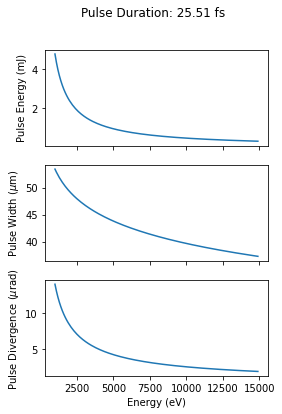

In [2]:
from matplotlib import pyplot as plt

energies = np.arange(1,15,0.1)*1e3 ### photon energies
q = 0.250 ### 250 pC bunch charge

fig, [ax1,ax2,ax3] = plt.subplots(3,1, figsize = (4,6), sharex = True)

duration = analytical_pulse_duration(q = 0.250)
fig.suptitle("Pulse Duration: {:.2f} fs".format(duration * 1e15))

pulse_energy = analytical_pulse_energy(q = q, photon_energy = energies)
ax1.plot(energies, pulse_energy * 1e3)
ax1.set_ylabel("Pulse Energy (mJ)")

pulse_width = analytical_pulse_width(photon_energy = energies)
ax2.plot(energies, pulse_width * 1e6)
ax2.set_ylabel("Pulse Width ($\mu$m)")

pulse_div = analytical_pulse_divergence(photon_energy = energies)
ax3.plot(energies, analytical_pulse_divergence(photon_energy = energies) * 1e6)
ax3.set_xlabel("Energy (eV)")
ax3.set_ylabel("Pulse Divergence ($\mu$rad)")

### A Custom SASE Source

We can use this model to generate pulses under a standard operating condition of the [SPB/SFX](http://scripts.iucr.org/cgi-bin/paper?S1600577519003308) instrument:

In [3]:
from phenom.source import SASE_Source

## define the operating conditions
photon_energy = 10e03
beam_charge = 0.250 # nC

## wrap sase
def SA1_Source(photon_energy,
               beam_charge,
               nr = 512, 
               nt = 512,
               bandwidth = 1e-04,
               x0 = 0.0,
               y0 = 0.0,
               t0 = 0.0,
               theta_x = 0.0,
               theta_y = 0.0):
    
    duration = analytical_pulse_duration(q = beam_charge)
    pulse_energy = analytical_pulse_energy(q = beam_charge, photon_energy = photon_energy)
    pulse_width = analytical_pulse_width(photon_energy = photon_energy)
    pulse_div = analytical_pulse_divergence(photon_energy = photon_energy)
    
    x = y = np.linspace(-pulse_width*4, pulse_width*4, nr)
    t = np.linspace(-duration*1.5, duration*1.5, nt)
    
    if type(pulse_width) == np.float64:
        pulse_width = float(pulse_width)
        
    ## define the pulse
    src = SASE_Source(x = x,
                      y = y,
                      t = t,
                      photon_energy = photon_energy,
                      pulse_energy = pulse_energy,
                      pulse_duration = duration,
                      bandwidth = bandwidth,
                      sigma = pulse_width,
                      div = pulse_div,
                      x0 = x0,
                      y0 = y0,
                      t0 = t0,
                      theta_x = theta_x,
                      theta_y = theta_y
                      )
    
    return src

It is then convenient to execute our wrapped function:

In [4]:
save_loc = "./sase_field.h5"

src = SA1_Source(photon_energy = 10e3, beam_charge = 0.250, nt = 252)
src.generate_pulses(save_loc)

Text(0.5, 0, 'Time (fs)')

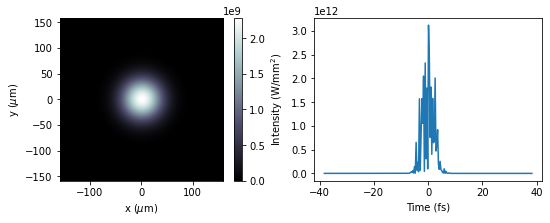

In [5]:
import h5py as h5

with h5.File(save_loc, mode = 'r') as hf:
    
    x = sase_pulse = hf['pulse000']['mesh']['x'][()]
    y = sase_pulse = hf['pulse000']['mesh']['y'][()]
    t = sase_pulse = hf['pulse000']['mesh']['t'][()]
    
    sase_pulse = hf['pulse000']['data'][()]
    
from matplotlib import pyplot as plt
 
fig, [ax1, ax2] = plt.subplots(1,2, figsize = (9,3))

### spatial intensity
im = ax1.imshow((abs(sase_pulse)**2).sum(axis = 2),
                extent = [x.min() * 1e06,
                          x.max() * 1e06,
                          y.min() * 1e06,
                          y.max() * 1e06],
                cmap = 'bone'
                )

plt.colorbar(im, label = "Intensity (W/mm$^2$)")

ax1.set_xlabel('x ($\mu$m)')
ax1.set_ylabel('y ($\mu$m)')


ax2.plot(t*1e15, (abs(sase_pulse)**2).sum(axis = (0,1)))
ax2.set_xlabel("Time (fs)")

We can similarly pass a list of photon_energies:

In [6]:
save_loc = "./sase_field.h5"

energies = np.arange(10,15)*1e3

src = SA1_Source(photon_energy = energies, beam_charge = 0.250, nt = 2)
src.generate_pulses(save_loc)

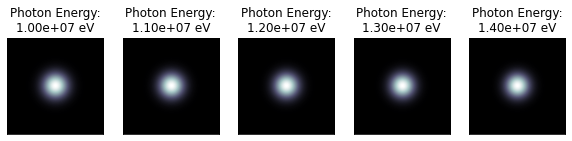

In [7]:
fig, ax = plt.subplots(1,5, figsize = (10,2))
ax = ax.flatten()

with h5.File(save_loc, mode = 'r') as hf:
    
    for itr, key in enumerate(hf.keys()):
        
        ax[itr].set_xticks([])
        ax[itr].set_yticks([])
        
        sase_pulse = hf[key]['data'][()]
        ax[itr].imshow((abs(sase_pulse)**2).sum(axis = 2),
                        cmap = 'bone'
                    )
        photon_energy = hf[key]['params']['photon_energy'][()]
        ax[itr].set_title("Photon Energy:\n{:.2e} eV".format(photon_energy*1e3))